In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
import scipy
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import statsmodels.formula.api as sm
import copy
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
import sklearn
from math import sqrt
from functools import reduce
import numpy as np
#import ee
#import geemap
import geopandas as gpd
import rioxarray as rxr
import rasterstats as rs
from rasterio.plot import show
import rasterio

%matplotlib inline
plt.rcParams["font.family"] = "Arial"

# RAINFED PARAMS --> NDVI

In [92]:
'''# NDVI SUM Data
points = '/Users/delatorredm/OneDrive - The University of Auckland/Ch4_Climate_Impacts/geospatial_layers/duration_seasonalCompositeNDVI_2017_SUM_JFM.gpkg'
points = gpd.read_file(points)
points = points.groupby(['Class','ADM3_EN']).mean().reset_index()
points = points.loc[points['Class']=='Rain-fed Rice']
points = points.rename(columns=dict(zip(list(points.columns[2:20]), list(np.arange(2001, 2019, 1)))))
points['param']='ndvi'
ndvi = points.melt(id_vars=["Class", "ADM3_EN", "param"], var_name="Date", value_name='value')
'''
# PCP
param_name = 'pcp'
params = '/Users/delatorredm/OneDrive - The University of Auckland/Ch4_Climate_Impacts/geospatial_layers/params_seasonalComposite_'+param_name+'_JFM.gpkg'
params = gpd.read_file(params).groupby(['Class','ADM3_EN']).mean().reset_index()
params = params.loc[params['Class']=='Rain-fed Rice']
params = params.rename(columns=dict(zip(list(params.columns[2:20]), list(np.arange(2001, 2019, 1)))))
params['param']= param_name
pcp = params.melt(id_vars=["Class", "ADM3_EN", "param"], var_name="Date", value_name='value')

# LST DAY
param_name = 'LST_Day_1km'
params = '/Users/delatorredm/OneDrive - The University of Auckland/Ch4_Climate_Impacts/geospatial_layers/params_seasonalComposite_'+param_name+'_JFM.gpkg'
params = gpd.read_file(params).groupby(['Class','ADM3_EN']).mean().reset_index()
params = params.loc[params['Class']=='Rain-fed Rice']
params = params.rename(columns=dict(zip(list(params.columns[2:20]), list(np.arange(2001, 2019, 1)))))
params['param']= param_name
lstday = params.melt(id_vars=["Class", "ADM3_EN", "param"], var_name="Date", value_name='value')

# LST NIGHT
param_name = 'LST_Night_1km'
params = '/Users/delatorredm/OneDrive - The University of Auckland/Ch4_Climate_Impacts/geospatial_layers/params_seasonalComposite_'+param_name+'_JFM.gpkg'
params = gpd.read_file(params).groupby(['Class','ADM3_EN']).mean().reset_index()
params = params.loc[params['Class']=='Rain-fed Rice']
params = params.rename(columns=dict(zip(list(params.columns[2:20]), list(np.arange(2001, 2019, 1)))))
params['param']= param_name
lstnight = params.melt(id_vars=["Class", "ADM3_EN", "param"], var_name="Date", value_name='value')

# ET
param_name = 'et'
params = '/Users/delatorredm/OneDrive - The University of Auckland/Ch4_Climate_Impacts/geospatial_layers/params_seasonalComposite_'+param_name+'_JFM.gpkg'
params = gpd.read_file(params).groupby(['Class','ADM3_EN']).mean().reset_index()
params = params.loc[params['Class']=='Rain-fed Rice']
params = params.rename(columns=dict(zip(list(params.columns[2:20]), list(np.arange(2001, 2019, 1)))))
params['param']= param_name
et = params.melt(id_vars=["Class", "ADM3_EN", "param"], var_name="Date", value_name='value')

# PET
param_name = 'pet'
params = '/Users/delatorredm/OneDrive - The University of Auckland/Ch4_Climate_Impacts/geospatial_layers/params_seasonalComposite_'+param_name+'_JFM.gpkg'
params = gpd.read_file(params).groupby(['Class','ADM3_EN']).mean().reset_index()
params = params.loc[params['Class']=='Rain-fed Rice']
params = params.rename(columns=dict(zip(list(params.columns[2:20]), list(np.arange(2001, 2019, 1)))))
params['param']= param_name
pet = params.melt(id_vars=["Class", "ADM3_EN", "param"], var_name="Date", value_name='value')

# ELEVATION
param_name = 'elevation'
params = '/Users/delatorredm/OneDrive - The University of Auckland/Ch4_Climate_Impacts/geospatial_layers/params_ch3_elevation.gpkg'
params = gpd.read_file(params).groupby(['Class','ADM3_EN']).mean().reset_index()
params = params.loc[params['Class']=='Rain-fed Rice']
params = params.rename(columns=dict(zip(list(params.columns[2:20]), list(np.arange(2001, 2019, 1)))))
params['param']= param_name
elevation = params.melt(id_vars=["Class", "ADM3_EN", "param"], var_name="Date", value_name='value')
elevation['Date'] = 2018

# SLOPE
param_name = 'slope'
params = '/Users/delatorredm/OneDrive - The University of Auckland/Ch4_Climate_Impacts/geospatial_layers/params_ch3_slope.gpkg'
params = gpd.read_file(params).groupby(['Class','ADM3_EN']).mean().reset_index()
params = params.loc[params['Class']=='Rain-fed Rice']
params = params.rename(columns=dict(zip(list(params.columns[2:20]), list(np.arange(2001, 2019, 1)))))
params['param']= param_name
slope = params.melt(id_vars=["Class", "ADM3_EN", "param"], var_name="Date", value_name='value')
slope['Date'] = 2018


In [93]:
# Subset temporally and pivot to table for linear regression
startYear = 2013
endYear = 2018
merged = pd.concat([pcp, lstday, lstnight, et, pet, elevation, slope])
subbed = merged[(merged.Date <= endYear) & (merged.Date >= startYear)].groupby(['ADM3_EN','param']).mean().reset_index(drop=False)
df = subbed.pivot(index="ADM3_EN", columns=["param"],values="value").reset_index(drop=False)

In [94]:
df['ndvi'] = 3.2355+0.0484*df.et-0.051*df.pet+0.0008*df.elevation

# NDVI --> YIELD

In [95]:
df['yield'] = -0.4620 + 5.2553*np.log(df.ndvi)
df.tail()

param,ADM3_EN,LST_Day_1km,LST_Night_1km,elevation,et,pcp,pet,slope,ndvi,yield
38,Santa Barbara,31.834735,21.902898,28.392857,22.767692,216.146875,49.457771,0.779793,1.837824,2.736283
39,Sara,29.887036,21.344896,96.879518,28.549604,371.895073,50.093532,3.184771,2.140034,3.536347
40,Tigbauan,32.143064,22.866046,33.863636,22.805808,184.932663,49.654798,1.537557,1.833997,2.725329
41,Tubungan,30.090048,21.219309,358.307692,26.685470,187.383085,53.023825,9.853274,2.109508,3.460843
42,Zarraga,30.518629,21.880994,9.400000,24.217037,236.285600,50.133796,0.212952,1.858301,2.794513


# ERRORS

<AxesSubplot:xlabel='value', ylabel='yield'>

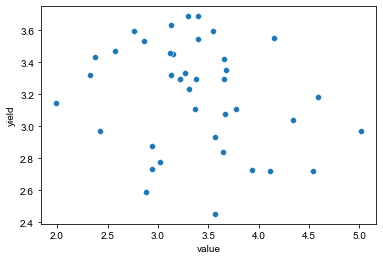

In [96]:
actual = pd.read_csv('/Users/delatorredm/OneDrive - The University of Auckland/Ch4_Climate_Impacts/iloilo_rice_data_cleaned_imputed_new.csv')
actual = actual[(actual.param == 'yield') & (actual.ecosystem == 'rf')].reset_index(drop=True)
actual = actual[(actual.year == 2018)].groupby('muni').mean().reset_index(drop=False)
actual.tail()


merged = pd.merge(actual, df, left_on='muni', right_on='ADM3_EN')
#merged = merged.loc[merged['ADM3_EN'].isin([
#'Carles',
#'Calinog',
#'Estancia',
#'Lambunao',
##'Cabatuan',
#'Duenas',
##'Santa Barbara',
#'Bingawan',
#'Maasin',
#'Badiangan'
#])]

sns.scatterplot(x='value',y='yield',data=merged)

# IRRIGAGTED

In [97]:
# PCP
param_name = 'pcp'
params = '/Users/delatorredm/OneDrive - The University of Auckland/Ch4_Climate_Impacts/geospatial_layers/params_seasonalComposite_'+param_name+'_JAS.gpkg'
params = gpd.read_file(params).groupby(['Class','ADM3_EN']).mean().reset_index()
params = params.loc[params['Class']=='Irrigated Rice']
params = params.rename(columns=dict(zip(list(params.columns[2:20]), list(np.arange(2001, 2019, 1)))))
params['param']= param_name
pcp = params.melt(id_vars=["Class", "ADM3_EN", "param"], var_name="Date", value_name='value')

# LST DAY
param_name = 'LST_Day_1km'
params = '/Users/delatorredm/OneDrive - The University of Auckland/Ch4_Climate_Impacts/geospatial_layers/params_seasonalComposite_'+param_name+'_JAS.gpkg'
params = gpd.read_file(params).groupby(['Class','ADM3_EN']).mean().reset_index()
params = params.loc[params['Class']=='Irrigated Rice']
params = params.rename(columns=dict(zip(list(params.columns[2:20]), list(np.arange(2001, 2019, 1)))))
params['param']= param_name
lstday = params.melt(id_vars=["Class", "ADM3_EN", "param"], var_name="Date", value_name='value')

# LST NIGHT
param_name = 'LST_Night_1km'
params = '/Users/delatorredm/OneDrive - The University of Auckland/Ch4_Climate_Impacts/geospatial_layers/params_seasonalComposite_'+param_name+'_JAS.gpkg'
params = gpd.read_file(params).groupby(['Class','ADM3_EN']).mean().reset_index()
params = params.loc[params['Class']=='Irrigated Rice']
params = params.rename(columns=dict(zip(list(params.columns[2:20]), list(np.arange(2001, 2019, 1)))))
params['param']= param_name
lstnight = params.melt(id_vars=["Class", "ADM3_EN", "param"], var_name="Date", value_name='value')

# ET
param_name = 'et'
params = '/Users/delatorredm/OneDrive - The University of Auckland/Ch4_Climate_Impacts/geospatial_layers/params_seasonalComposite_'+param_name+'_JAS.gpkg'
params = gpd.read_file(params).groupby(['Class','ADM3_EN']).mean().reset_index()
params = params.loc[params['Class']=='Irrigated Rice']
params = params.rename(columns=dict(zip(list(params.columns[2:20]), list(np.arange(2001, 2019, 1)))))
params['param']= param_name
et = params.melt(id_vars=["Class", "ADM3_EN", "param"], var_name="Date", value_name='value')

# PET
param_name = 'pet'
params = '/Users/delatorredm/OneDrive - The University of Auckland/Ch4_Climate_Impacts/geospatial_layers/params_seasonalComposite_'+param_name+'_JAS.gpkg'
params = gpd.read_file(params).groupby(['Class','ADM3_EN']).mean().reset_index()
params = params.loc[params['Class']=='Irrigated Rice']
params = params.rename(columns=dict(zip(list(params.columns[2:20]), list(np.arange(2001, 2019, 1)))))
params['param']= param_name
pet = params.melt(id_vars=["Class", "ADM3_EN", "param"], var_name="Date", value_name='value')

# ELEVATION
param_name = 'elevation'
params = '/Users/delatorredm/OneDrive - The University of Auckland/Ch4_Climate_Impacts/geospatial_layers/params_ch3_elevation.gpkg'
params = gpd.read_file(params).groupby(['Class','ADM3_EN']).mean().reset_index()
params = params.loc[params['Class']=='Irrigated Rice']
params = params.rename(columns=dict(zip(list(params.columns[2:20]), list(np.arange(2001, 2019, 1)))))
params['param']= param_name
elevation = params.melt(id_vars=["Class", "ADM3_EN", "param"], var_name="Date", value_name='value')
elevation['Date'] = 2018

# SLOPE
param_name = 'slope'
params = '/Users/delatorredm/OneDrive - The University of Auckland/Ch4_Climate_Impacts/geospatial_layers/params_ch3_slope.gpkg'
params = gpd.read_file(params).groupby(['Class','ADM3_EN']).mean().reset_index()
params = params.loc[params['Class']=='Irrigated Rice']
params = params.rename(columns=dict(zip(list(params.columns[2:20]), list(np.arange(2001, 2019, 1)))))
params['param']= param_name
slope = params.melt(id_vars=["Class", "ADM3_EN", "param"], var_name="Date", value_name='value')
slope['Date'] = 2018


In [98]:
# Subset temporally and pivot to table for linear regression
startYear = 2013
endYear = 2018
merged = pd.concat([pcp, lstday, lstnight, et, pet, elevation, slope])
subbed = merged[(merged.Date <= endYear) & (merged.Date >= startYear)].groupby(['ADM3_EN','param']).mean().reset_index(drop=False)
df = subbed.pivot(index="ADM3_EN", columns=["param"],values="value").reset_index(drop=False)

In [99]:
df['ndvi'] = -0.5806+0.061*df['LST_Night_1km']+0.0273*df['pet']

In [100]:
df['ndvi'] = 1.6462 -0.0001*df['pcp']+0.0963*df['LST_Day_1km']-0.1354*df['LST_Night_1km']+0.0071*df.et+0.0248*df.pet-0.0037*df.elevation-0.1161*df.slope

# NDVI --> YIELD

In [101]:
df['yield'] = -0.1575 + 1.9984*np.log(df.ndvi)
df['yield'] = np.log(df['yield'])
df.tail()

param,ADM3_EN,LST_Day_1km,LST_Night_1km,elevation,et,pcp,pet,slope,ndvi,yield
13,Pototan,30.744924,23.291397,17.400000,27.648587,952.062069,37.780112,0.339282,2.387556,0.458467
14,San Miguel,30.992687,23.261250,29.750000,24.119444,1090.653920,35.348611,0.206249,2.286030,0.402000
15,Santa Barbara,31.101917,23.145500,23.500000,27.386111,1064.460749,38.327431,0.699230,2.377799,0.453280
16,Tigbauan,29.979307,22.669418,25.181818,25.756608,1212.176539,36.925379,0.547456,2.284439,0.401068
17,Zarraga,30.374417,23.425447,8.727273,25.424884,963.359675,35.930540,0.275814,2.310396,0.416074


# ERRORS

<AxesSubplot:xlabel='log_actual', ylabel='yield'>

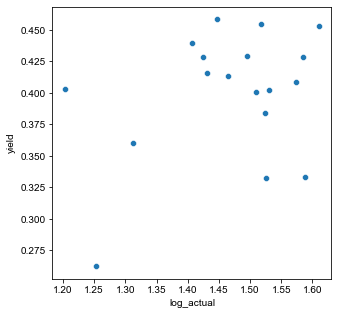

In [102]:
actual = pd.read_csv('/Users/delatorredm/OneDrive - The University of Auckland/Ch4_Climate_Impacts/iloilo_rice_data_cleaned_imputed_new.csv')
actual = actual[(actual.param == 'yield') & (actual.ecosystem == 'irri')].reset_index(drop=True)
actual = actual[(actual.year == 2018)].groupby('muni').mean().reset_index(drop=False)
actual.tail()


merged = pd.merge(actual, df, left_on='muni', right_on='ADM3_EN')
merged['log_actual'] = np.log(merged['value'])

fig, ax = plt.subplots(figsize=(5,5))
sns.scatterplot(x='log_actual',y='yield',data=merged, ax=ax)
#plt.plot([2,4],[2,4])